# Final Project Submission

**Student Name:** Peter Otieno  
**Student Pace:** Full time  
**Scheduled Project Review Date/Time:** 9/12/23  
**Instructor Name:** Lucille Kaleha  




# Microsoft Goes to the Movies

## Overview
This project analyzes current box office and movie trends to make recommendations to Microsoft Corporation. Namely:
-   Why should Microsoft get into the movie making space?
- What movie genres are currently performing well and should be focused on? Both with the regular movie going audience as well as critics.
- What can Microsoft bring to the table that other companies cannot?
 
The first two questions can generally be answered by looking at different movie trends in the last few years. The latter would require delving into Microsoft's unique position in the space and leveraging their list of growing IPs
 
## Business Problem
Having seen the commercial and critical success enjoyed by companies like Netflix, Amazon, Apple, and HBO, prominent stakeholders at Microsoft have decided to launch a film/television studio. However, they have no clue as to *what kind* of movies they should be making in order to be competitive. We will need to analyze various datasets to provide evidence-based recommendations for Microsoft’s 
 
 ## Data
To generate revenue based trends and data we used data from *www.the-numbers.com* which provides detailed movie financial analysis, including box office, DVD and Blu-ray sales reports, and release schedules. We will be focusing primarily on box office earnings to comment on industry trends.
 
This report also utilizes *www.imdb.com* and *rottentomatoes.com*. Both websites are run off of user interaction and user generated content regarding different movies. The former being an indicator of popularity of various titles using a review and rating system, and the latter being a review aggregator as posted by critics. We shall employ these sites to see what genres are popular by both regular viewers and critics.
 
Microsoft has acquired a few new companies in the last few years especially in the video games sector. This makes Microsoft uniquely positioned to leverage IPs that they hold to make original content or maybe even licensing. Webscraping was used to gather some of this data. 
In conjunction with this we shall cross reference a sales dataset to see what video game IPs Microsoft owns that are popular and make direct video game adaptation recommendations.

# Outline of the Notebook


- Working with dataset from TheNumbers
- Rotten Tomatoes Data Set
- Understanding The IMBD Data Set
- Exploring Microsofts IPs within the Gaming Industry

Imported All Libraries Used

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")


## Working with dataset from 'The-Numbers.com'

In [4]:
#Load 'The Numbers' dataset
tn_df = pd.read_csv('tn.movie_budgets.csv')
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
tn_df.shape

(5782, 6)

In [6]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The dataset has no null values and includes columns for production_budget, domestic_gross and worldwide_gross however, they are all strings. First lets confirm that all numbers are dealing in the same currency ('$')

In [7]:
print("Is the production budget in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the domestic gross in dollars for all records?: ",tn_df['domestic_gross'].str.startswith('$').sum() == len(tn_df))
print("Is the worldwide gross in dollars for all records?: ",tn_df['worldwide_gross'].str.startswith('$').sum() == len(tn_df))

Is the production budget in dollars for all records?:  True
Is the domestic gross in dollars for all records?:  True
Is the worldwide gross in dollars for all records?:  True


It looks all the business related data is in dollars. We can safely convert all the numbers without having to do any currency conversions. To ensure we don't lose track, a currency column is created to include the "$" symbol and all numbers are then proceeded to be converted to numbers

In [8]:
#Converting production buget, domestic gross, worldwide gross to numbers, Add currency unit column as a reminder 
#numbers are in $
tn_df['currency'] = '$'
tn_df['production_budget'] = tn_df['production_budget'].str.replace(',','').str.replace('$','').astype(int)
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace(',','').str.replace('$','').astype(int)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace(',','').str.replace('$','').astype('int64')

Using these we can calculate the net revenue a movie generated

In [9]:
#Adding net revenue column and a foreign gross column
tn_df['foreign_gross'] = tn_df['worldwide_gross'] - tn_df['domestic_gross']
tn_df['net_revenue'] = tn_df['worldwide_gross'] - tn_df['production_budget']

Converting release_date to date time and appending month and year columns

In [10]:
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])
tn_df['release_year'] = tn_df['release_date'].dt.year
tn_df['release_month'] = tn_df['release_date'].dt.month

Checking the design of the new dataframe

In [11]:
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,currency,foreign_gross,net_revenue,release_year,release_month
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,$,2015837654,2351345279,2009,12
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,$,804600000,635063875,2011,5
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,$,107000000,-200237650,2019,6
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,$,944008095,1072413963,2015,5
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,$,696540365,999721747,2017,12


## Why should Microsoft get into movies?

Aside from owning IPs that lend itself to making good visual content, we can ascertain whether there is a business reason to get into movie making.Lets look at gross and net revenue performance of the box office by the year for the last 20 years

In [12]:
# Filtering the dataframe to remove entries with 0 for revenue and gross
filtered_df = tn_df[(tn_df['worldwide_gross'] != 0) & (tn_df['net_revenue'] != 0)]

# Further filtering to restrict the release years
years_filtered_df = filtered_df[(filtered_df['release_year'] >= 2000) & (filtered_df['release_year'] <= 2018)]

# Grouping by 'release_year' and calculating the mean for 'worldwide_gross' and 'net_revenue'
trend_viz_df = years_filtered_df.groupby('release_year').agg({
    'worldwide_gross': 'mean',
    'net_revenue': 'mean'
}).reset_index()


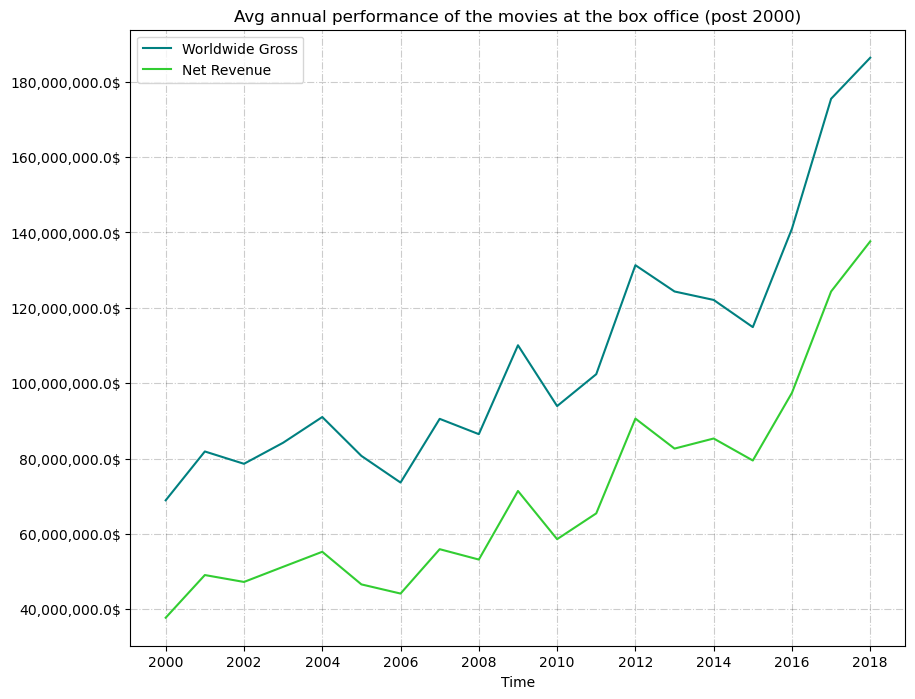

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(list(trend_viz_df['release_year']), list(trend_viz_df['worldwide_gross']),'teal')
ax.plot(list(trend_viz_df['release_year']), list(trend_viz_df['net_revenue']),'limegreen')

ax.set_xlabel('Time')
ax.set_xticks(np.arange(2000,2020,2))
ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,}$'))

ax.set_title('Avg annual performance of the movies at the box office (post 2000)')
ax.legend(['Worldwide Gross','Net Revenue'])
ax.grid(c='k',ls= '-.',alpha = 0.2);

# fig.savefig('./images/AnnualMeanPerformance.jpg',
#             transparent = False);

## Best Release time of the year

Limiting data to post Insert cut off year or essentially last 10 years worth of data. This will help us to emphasize more recent trends. For the purpose of visualization we will be using world wide earnings. Dropping records with no world wide earnings data

In [13]:
# Paring down the dataset by a cutoff year to ascertain more recent trends focusing on worldwide revenue
reduced_df = tn_df[tn_df['release_year']>=2012]
reduced_df_worldwide = reduced_df.drop(reduced_df[reduced_df['worldwide_gross']==0].index)

Using the revenue data we can try to ascertain the best release windows for movies. We can see major revenue being generated during the summer season (May, June, July) and again during holiday season

In [14]:
df = reduced_df_worldwide.groupby('release_month')[['worldwide_gross', 'net_revenue']].mean()


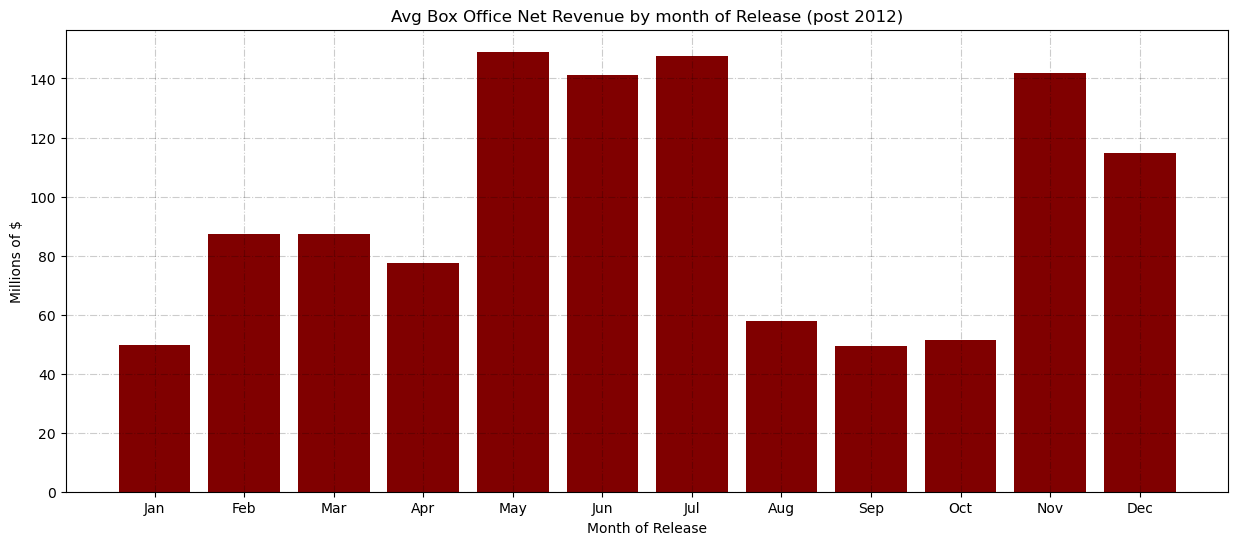

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(df.index, df['net_revenue'] / 1000000, color='maroon')
ax.set_title(f'Avg Box Office Net Revenue by month of Release (post 2012)')
ax.set_xlabel('Month of Release')
ax.set_ylabel('Millions of $')
ax.grid(c='k', ls='-.', alpha=0.2)

plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

ax.get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:g}'))
plt.show()


# RottenTomatoes dataset

In [17]:
#Load review info from Rotten Tomatoes
rt_review_df = pd.read_csv('rt.reviews.tsv',delimiter='\t',encoding = 'unicode_escape')
rt_review_df['publisher'].fillna('N/A',inplace = True)

# Don't need written review. Date in this instance is review date and irrelevant
rt_review_df.drop(columns = ['review','date'], inplace = True)
rt_review_df['fresh_flag'] = (rt_review_df['fresh']=='fresh') #creates a boolean column for 'fresh'/'rotten'

rt_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   rating      40915 non-null  object
 2   fresh       54432 non-null  object
 3   critic      51710 non-null  object
 4   top_critic  54432 non-null  int64 
 5   publisher   54432 non-null  object
 6   fresh_flag  54432 non-null  bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 2.5+ MB


In [18]:
rt_review_df.head()

,id,rating,fresh,critic,top_critic,publisher,fresh_flag
0,3,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,True
1,3,NaN,rotten,Annalee Newitz,0,io9.com,False
2,3,NaN,fresh,Sean Axmaker,0,Stream on Demand,True
3,3,NaN,fresh,Daniel Kasman,0,MUBI,True
4,3,NaN,fresh,NaN,0,Cinema Scope,True


In [18]:
rt_review_df.shape

(54432, 7)

ID in this table is a unique movie identifier across rotten tomato datasets.
A movie can have multiple reviews. Therefore, we can get the 'Fresh' rating across all review and across all 'top critics' for every ID

In [19]:
#Paring the data down to only the 'top critics'
#This returns a series of tomato ratings as rated by top critics. Index by id
top_critics = rt_review_df[rt_review_df['top_critic'] == 1]
grouped = top_critics.groupby('id')
mean_values = grouped['fresh_flag'].mean()


In [20]:
#This returns a series of tomato ratings as rated by all critics. Index by id
all_reviews_sr = rt_review_df.groupby('id').agg({'fresh_flag': 'mean'})['fresh_flag']


In [21]:
#Load movie info from Rotten Tomatoes
rt_movie_df = pd.read_csv('rt.movie_info.tsv',delimiter = '\t')

# NOTE: No movie title provided in dataset. And unique identifier 'id' cannot be matched
# to another db.

#Create list of genres for each record
rt_movie_df['genre list'] = rt_movie_df['genre'].str.split('|')

# Convert runtime to numerical data
rt_movie_df['runtime_in_min'] = rt_movie_df['runtime'].map(lambda x: int(x[:-8]) if x is not np.nan else np.nan)

# Converting theater date to datetime object and creating year column
rt_movie_df['theater_date'] = pd.to_datetime(rt_movie_df['theater_date'])
rt_movie_df['year'] = rt_movie_df['theater_date'].dt.year

#'currency' and 'box_office' columns are about 4/5 empty. Dropping these columns. 
# Other datasets are morecomplete and this data can be gathered from there instead 
# Dropping synopsis and studio as well
rt_movie_df.drop(columns = ['synopsis','currency','box_office','studio','runtime'],inplace=True)

In [22]:
rt_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1560 non-null   int64         
 1   rating          1557 non-null   object        
 2   genre           1552 non-null   object        
 3   director        1361 non-null   object        
 4   writer          1111 non-null   object        
 5   theater_date    1201 non-null   datetime64[ns]
 6   dvd_date        1201 non-null   object        
 7   genre list      1552 non-null   object        
 8   runtime_in_min  1530 non-null   float64       
 9   year            1201 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 122.0+ KB


Having calculated the 'Fresh' meter for each movie already we can create a column for each and add it to this master table

In [22]:
rt_movie_df['overall_tomato_rating'] = rt_movie_df['id'].map(lambda x: all_reviews_sr[x] if x in all_reviews_sr else np.nan)
rt_movie_df['top_critic_tomato_rating'] = rt_movie_df['id'].map(lambda x: top_critics[x] if x in top_critics else np.nan)

## Genre Performance

Drop every record with a na in genre. Create a boolean matrix for all different genres. Drop unneccessary columns

In [30]:
unique_genre_list = []
for genres in rt_movie_df['genre list'].dropna().tolist():
    for genre in genres:
        unique_genre_list.append(genre)
unique_genre_list =list(set(unique_genre_list))

In [31]:
rt_movie_genre_df = rt_movie_df[rt_movie_df['genre list'].notna()]


for genre in unique_genre_list:
    rt_movie_genre_df[genre] = rt_movie_genre_df['genre list'].map(lambda x: True if genre in x else False)

In [34]:
print(rt_movie_genre_temp.info())


<class 'pandas.core.frame.DataFrame'>
Index: 127 entries, 16 to 1537
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   director                     117 non-null    object        
 1   writer                       111 non-null    object        
 2   theater_date                 127 non-null    datetime64[ns]
 3   Musical and Performing Arts  127 non-null    bool          
 4   Sports and Fitness           127 non-null    bool          
 5   Action and Adventure         127 non-null    bool          
 6   Horror                       127 non-null    bool          
 7   Kids and Family              127 non-null    bool          
 8   Classics                     127 non-null    bool          
 9   Animation                    127 non-null    bool          
 10  Anime and Manga              127 non-null    bool          
 11  Cult Movies                  127 non-null    boo

In [36]:
# Drop the non-boolean columns
rt_movie_genre_temp_cleaned = rt_movie_genre_temp.drop(columns=['director', 'writer', 'theater_date'])

# Calculate the sum for each genre column
genre_sums = rt_movie_genre_temp_cleaned.sum()

# Sort the genres in descending order based on the sum
sorted_genres = genre_sums.sort_values(ascending=False)

# Extract the top 15 genres
top_15_genres = list(sorted_genres[:15].index)

print(top_15_genres)


['Drama', 'Comedy', 'Mystery and Suspense', 'Action and Adventure', 'Romance', 'Science Fiction and Fantasy', 'Art House and International', 'Horror', 'Kids and Family', 'Animation', 'Musical and Performing Arts', 'Western', 'Documentary', 'Special Interest', 'Faith and Spirituality']


In [41]:
# Drop the non-boolean columns
rt_movie_genre_temp_cleaned = rt_movie_genre_temp.drop(columns=['director', 'writer', 'theater_date'])

# Calculate the sum for each genre column
genre_sums = rt_movie_genre_temp_cleaned.sum()

# Sort the genres in descending order based on the sum
sorted_genres_descending = genre_sums.sort_values(ascending=False)

# Extract the counts and names of the top 15 genres
top_15_genre_counts_descending = sorted_genres_descending.head(15)

# Print the results
print(top_15_genre_counts_descending)


Drama                          74
Comedy                         39
Mystery and Suspense           24
Action and Adventure           18
Romance                        16
Science Fiction and Fantasy    12
Art House and International    11
Horror                          8
Kids and Family                 7
Animation                       5
Musical and Performing Arts     4
Western                         3
Documentary                     2
Special Interest                2
Faith and Spirituality          1
dtype: int64


In [43]:
viz_data = []

for genre in top_15_genres:
    # Filter for movies that belong to the current genre and were released after 2012
    genre_df = rt_movie_genre_df[(rt_movie_genre_df[genre] == True) & (rt_movie_genre_df['year'] > 2012)]
    
    # Calculate the mean ratings for this subset of movies
    overall_rating_mean = genre_df['overall_tomato_rating'].mean()
    top_critic_rating_mean = genre_df['top_critic_tomato_rating'].mean()

    # Append the results to viz_data
    viz_data.append([genre, overall_rating_mean, top_critic_rating_mean])

# Sort the data by the overall tomato rating
viz_data.sort(key=lambda x: x[1], reverse=True)


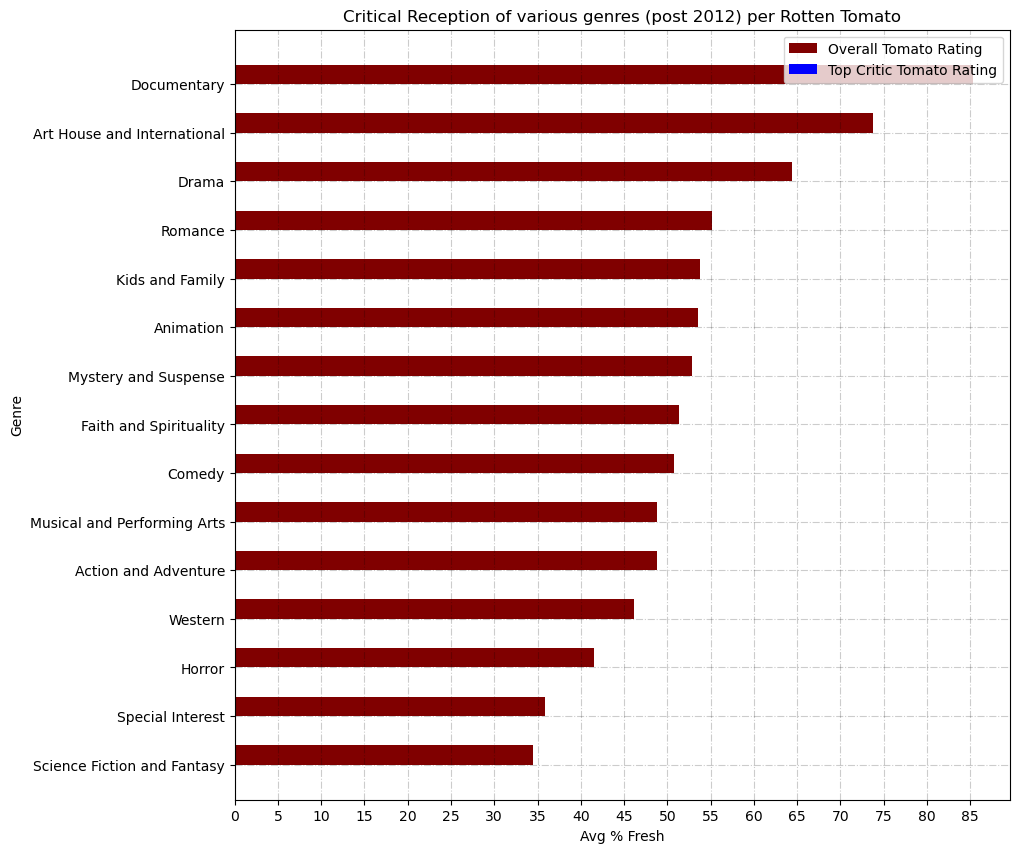

In [46]:
# Visualization
viz_labels = [v[0] for v in viz_data]
viz_all_ratings = [v[1]*100 for v in viz_data]
viz_top_ratings = [v[2]*100 for v in viz_data]

y = np.arange(len(viz_labels))
h = 0.6

fig, ax = plt.subplots(figsize=(10,10))


ax.grid(c='k',ls= '-.',alpha = 0.2);

ax.set_title(f'Critical Reception of various genres (post 2012) per Rotten Tomato')
ax.set_ylabel('Genre')
ax.set_xlabel('Avg % Fresh')

ax.barh(y-h/3, viz_all_ratings, h/1.5,color='maroon')
ax.barh(y+h/3, viz_top_ratings, h/1.5,color='blue')

ax.set_xticks(np.arange(0, 90, step=5))

ax.set_yticks(y)  
ax.set_yticklabels(labels=viz_labels)
ax.legend(['Overall Tomato Rating', 'Top Critic Tomato Rating'])
ax.invert_yaxis()

# fig.savefig('./images/PopularGenres_Critics.jpg',
#             transparent = False,bbox_inches="tight");

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

## Runtime Performance

Finding a corelation  between Runtime Performance and critical performance

In [60]:
# Filter movies based on a specified runtime range
rt_runtime_df = rt_movie_df.dropna(subset=['runtime_in_min', 'overall_tomato_rating', 'top_critic_tomato_rating'])
filtered_rt_runtime_df = rt_runtime_df[(rt_runtime_df['runtime_in_min'] > 5) & (rt_runtime_df['runtime_in_min'] < 300)]


In [61]:

if len(filtered_rt_runtime_df) > 0:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x=filtered_rt_runtime_df['runtime_in_min'], y=filtered_rt_runtime_df['overall_tomato_rating'], alpha=0.4)
    ax[1].scatter(x=filtered_rt_runtime_df['runtime_in_min'], y=filtered_rt_runtime_df['top_critic_tomato_rating'], alpha=0.4)
    
    ax[0].set_title("Overall Tomato Rating vs. Runtime")
    ax[1].set_title("Top Critic Tomato Rating vs. Runtime")
    
    ax[0].set_xlabel("Runtime in Minutes")
    ax[1].set_xlabel("Runtime in Minutes")
    ax[0].set_ylabel("Overall Tomato Rating")
    ax[1].set_ylabel("Top Critic Tomato Rating")
    plt.show()
else:
    print("No data left to plot after filtering.")


No data left to plot after filtering.


In [62]:
print(rt_movie_df['runtime_in_min'].describe())


count    1530.000000
mean      103.967974
std        24.642392
min         5.000000
25%        91.000000
50%       100.000000
75%       114.000000
max       358.000000
Name: runtime_in_min, dtype: float64


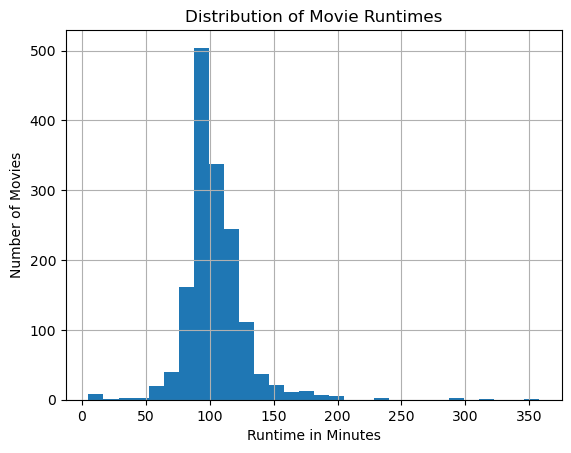

In [63]:
rt_movie_df['runtime_in_min'].hist(bins=30)
plt.title("Distribution of Movie Runtimes")
plt.xlabel("Runtime in Minutes")
plt.ylabel("Number of Movies")
plt.show()


In [55]:
rt_runtime_df = rt_runtime_df[
    (rt_runtime_df['runtime_in_min'] > (runtime_q1 - 1.5 * runtime_iqr)) &
    (rt_runtime_df['runtime_in_min'] < (runtime_q3 + 1.5 * runtime_iqr))
]


In [58]:
print(rt_movie_df['runtime_in_min'].describe())


count    1530.000000
mean      103.967974
std        24.642392
min         5.000000
25%        91.000000
50%       100.000000
75%       114.000000
max       358.000000
Name: runtime_in_min, dtype: float64


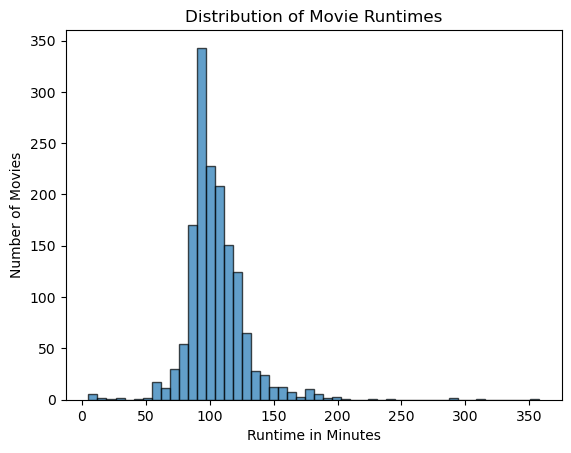

In [59]:
plt.hist(rt_movie_df['runtime_in_min'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title("Distribution of Movie Runtimes")
plt.xlabel("Runtime in Minutes")
plt.ylabel("Number of Movies")
plt.show()


In [56]:
print("Number of entries left:", len(rt_runtime_df))


Number of entries left: 0


In [57]:
if len(rt_runtime_df) > 0:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].scatter(x=rt_runtime_df['runtime_in_min'], y=rt_runtime_df['overall_tomato_rating'], alpha=0.4)
    ax[1].scatter(x=rt_runtime_df['runtime_in_min'], y=rt_runtime_df['top_critic_tomato_rating'], alpha=0.4)
    ax[0].set_title("Overall Tomato Rating vs. Runtime")
    ax[1].set_title("Top Critic Tomato Rating vs. Runtime")
    ax[0].set_xlabel("Runtime in Minutes")
    ax[1].set_xlabel("Runtime in Minutes")
    ax[0].set_ylabel("Overall Tomato Rating")
    ax[1].set_ylabel("Top Critic Tomato Rating")
    plt.show()
else:
    print("No data left to plot after filtering.")


No data left to plot after filtering.


In [51]:
rt_runtime_df = rt_runtime_df[(rt_runtime_df['runtime_in_min']>(runtime_q1 - 1.5*runtime_iqr)) & 
              (rt_runtime_df['runtime_in_min']<(runtime_q3 + 1.5*runtime_iqr))]

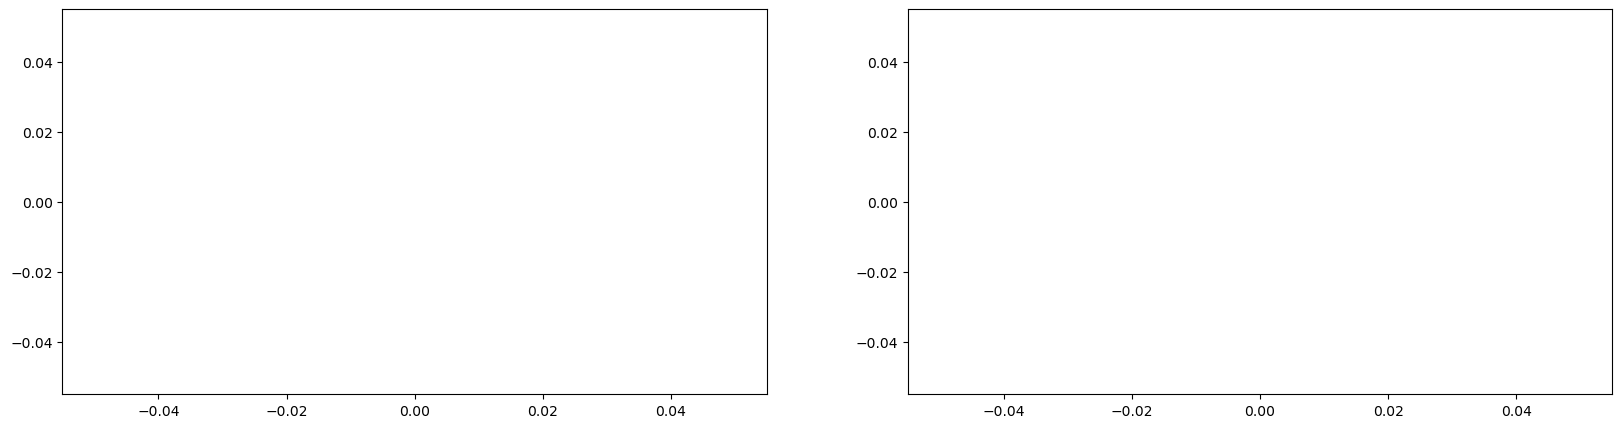

In [52]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].scatter(x= rt_runtime_df['runtime_in_min'],y = rt_runtime_df['overall_tomato_rating'], alpha =0.4);
ax[1].scatter(x= rt_runtime_df['runtime_in_min'],y = rt_runtime_df['top_critic_tomato_rating'], alpha =0.4);

# IMDb Dataset

First, we'll need to set up our notebook to be able to process this data.

In [ ]:
# Create connection to IMDb DB
con = sqlite3.connect('im.db')

Let's take a look at what this dataset actually *contains*, i.e. the names of the tables

In [ ]:
pd.read_sql("""

SELECT *
FROM sqlite_master

""",con)

Let's take a look at what this dataset actually *contains*, i.e. the names of the tables

In [ ]:
basics_query = """SELECT * FROM movie_basics"""

pd.read_sql(basics_query,con).info()

146,144 entries - that's a **lot** of movies!

We have a few columns with null values: ```original_title```, ```runtime_minutes```, and ```genres```. We'll have to figure out how to deal with those in due time, but first, let's get a closer look at what's actually contained in the table.

In [ ]:
pd.read_sql(basics_query,con).head(10)

Since most of the movies in the dataset have the same `primary_title` and `original_title`, and because `primary_title` is often an English-translated title, we can probably drop `original_title` when we join these tables.

We also have a primary key: `movie_id`.

Okay, what about the table `movie_ratings`?

In [ ]:
ratings_query = """SELECT * FROM movie_ratings"""

pd.read_sql(ratings_query,con).head(10)

That table is easy enough to read, but it only gives us **alphanumeric values** to identify what movie is associated with a given row's `averagerating` and `numvotes`. We will address that when we join the tables.

Let's take a more bird's-eye view of the `movie_ratings` table using `.info()`.

In [ ]:
pd.read_sql(ratings_query,con).info()

No null values in any of the three columns! But `movie_ratings`, with 73,856 rows, has only *half* as many entries as `movie_basics` - that means there are a lot of entries in `movie_basics` without an associated rating.

The two tables have `movie_id` in common, so we'll join them on that column.

Which column should we investigate first in order to get a sense of what movies (and what kinds of movies) are popular: `averagerating` or `numvotes`?

The values in the column `averagerating` provide us an idea of what *scores* IMDb users have assigned a movie (i.e. users' *evaluations* of a movie's quality), but `numvotes` tells us *how many* IMDb users have rated the movie, which likely gives us a better idea of a movie's **reach**. Let's order our data by `numvotes` to start.

In [ ]:
# Creating new query: Joining movie_basics and
# movie_ratings, ordering by total # of ratings

votes_query = """
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset) for last ten years' of data
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
"""

# Creating new dataframe based on votes_query
sample_df = pd.read_sql(votes_query,con)

In [ ]:
# Assigning the values from '# of Ratings' column to
# new variable ratings_counts
ratings_counts = sample_df['# of Ratings']

# Plotting ratings_counts as a boxplot
fig, ax = plt.subplots(figsize=(10,6))

plt.tick_params(
    axis='y',
    which='both',
    left=False,
    labelleft=False)

ax.boxplot(ratings_counts, vert=False)
ax.set_title("Count of User Ratings for Movies on IMDb")
ax.set_xlabel("# of Ratings (in millions)");

That is a very skewed boxplot - it's hard to even make any sense of it. Let's look at the descriptive statistics for the `# of Ratings` column.

In [ ]:
ratings_counts.describe().apply(lambda x: format(x, 'f'))

(The function to convert the output of `ratings_counts.describe()` from scientific notation to the above notation was provided by [Ash Upadhyay](https://stackoverflow.com/posts/47207283/revisions).)

Wow... not only is our ```mean``` well above the ```50%``` value (the median), but it's **more than ten times larger** than the ```75%``` value! The most popular movie on the site is represented by `max` and has 1,841,066 ratings. 

From a business perspective, it probably doesn't make a lot of sense to home in on movies with low numbers of user ratings. In the SQL query below, we order by `numvotes`/`# of Ratings` once again, but we limit our output to 500. This yields a dataframe with information about the 500 movies with the greatest number of user ratings - not only is it more manageable than working with thousands of records, we're also only working movies that are verifiably **popular** with IMDb users.

In [ ]:
imdb_df_sample = pd.read_sql("""
    SELECT
        -- Importing columns from movie_basics
        mb.primary_title AS "Title",
        mb.start_year AS "Release Year",
        mb.genres AS "genres",
        mb.runtime_minutes AS "Runtime",
        -- Importing columns from movie_ratings
        mr.averagerating AS "Avg. Rating",
        mr.numvotes AS "# of Ratings"
    FROM
        movie_basics AS mb
        JOIN movie_ratings AS mr
            ON mb.movie_id = mr.movie_id
    WHERE
        -- Looking at movies only with more than 100,000
        -- user ratings
        mr.numvotes >= 100000 AND
        -- Looking at movies only from 2010-2019 (most recent
        -- year in dataset)
        mb.start_year >= 2010
    ORDER BY
        mr.numvotes DESC
    LIMIT 500
""",con)

print(imdb_df_sample.info())

Okay, so we've got a sample of 500 movies, each of which has been rated *at least* 100,000 times by IMDb users (though we cannot guarantee these are all unique users.) This sample represents the 500 movies on the site with the greatest number of user ratings.

In [ ]:
# Database column 'genres' gives us multiple genres separated
# by commas -- using split() to create a LIST of genres
imdb_df_sample['genres'] = imdb_df_sample['genres'].str.split(',')

# Let's look at the 10 movies with the highest # of user ratings
imdb_df_sample.head(10)

It looks like we have a pretty wide range of runtimes, and several of the movies with the highest average ratings on the site clock in at **over 2.5 hours!** Given the lack of correlation between a movie's runtime and its performance with critics we observed in the RottenTomatoes data, we can safely drop ```runtime_minutes``` / ```Runtime``` and focus on the other columns instead.

In [ ]:
imdb_df_sample.drop(columns=['Runtime'], inplace=True)

Let's get a closer look at the `genres` column so that we can figure out what genres occur most frequently in this set of movies with 100,000+ user ratings.

In [ ]:
imdb_df_sample['genres']

Looks like the ```genres``` column has a *list* of genres for each entry. We're going to need to split those lists up in order to get accurate value counts for each genre. (Credit for this function goes to [Max Hilsdorf](https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173).)

In [ ]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# Top ten most frequently occurring genres
top_genres = to_1D(imdb_df_sample['genres']).value_counts().head(10)

In [ ]:
# Plotting top ten genres
genres_fig, ax = plt.subplots(figsize = (11, 6))

ax.invert_yaxis()
ax.barh(y=top_genres.index,
       width=top_genres,
       color='maroon',)
ax.set_title("Popular Genres w/ IMDb Users, 2010-2019")
ax.set_xlabel("# of Movies with Genre Tag")
ax.set_ylabel("Genre");

Interesting. It looks like `Action` is the most popular genre, with nearly **half** of the 500 most-frequently-rated movies containing `Action` in their list of genres!

`Drama` and `Adventure` sit in the second and third place slots, respectively, with `Comedy` in fourth place; this lends credence to the interpretation that `Drama` films reach a wider swath of moviegoers, though `Comedy` remains very popular. `Thriller` movies round out the top five.

If we subset our data so that we're only looking at the most recent five years' worth of data, do these trends change at all? Let's find out.

In [ ]:
# Obtaining a dataframe of only movies released 2015-2019
late_decade_df = imdb_df_sample[imdb_df_sample['Release Year'] >= 2015]

# Creating another list of top ten genres
genres2 = to_1D(late_decade_df['genres']).value_counts().head(10)

# Creating a second graph
genres_fig2, ax = plt.subplots(2, figsize = (11, 12))

ax[0].invert_yaxis()
ax[0].barh(y=genres2.index,
       width=genres2,
       color='purple')
ax[0].set_title("Popular Genres w/ IMDb Users, 2015-2019 only")
ax[0].set_xlabel("# of Movies with Genre Tag")
ax[0].set_ylabel("Genre")

ax[1].invert_yaxis()
ax[1].barh(y=top_genres.index,
       width=top_genres,
       color='orange',)
ax[1].set_title("Popular Genres w/ IMDb Users, 2010-2019")
ax[1].set_xlabel("# of Movies with Genre Tag")
ax[1].set_ylabel("Genre")
genres_fig2.tight_layout(pad=3.0)


These graphs are pretty comparable, both in their shapes and in their distributions of genres. We can observe an uptick in the popularity of `Sci-Fi` in the latter half of the 2010s, slightly eclipsing the popularity of `Thriller` movies (`Thriller` drops to 8<sup>th</sup> place, below `Crime` and `Fantasy`). The differences between the graphs are not profound or significant, but we can definitely comment on the increased profile of `Sci-Fi` films in the last five years' of data.

# Exploring Microsofts Gaming IPs

Grabbed single chart from Wiki listing Microsoft Acquisitions

In [ ]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_mergers_and_acquisitions_by_Microsoft')
soup = BeautifulSoup(r.text)
table = soup.find('table', {'class': "wikitable sortable"})

In [ ]:
len(table.find_all('tr')) 
#Checking to see if the length of the table matches the table on Wiki

In [ ]:
Microsoft_Acquisitions_df = pd.read_html(table.prettify())[0]
Microsoft_Acquisitions_df.head()

In [ ]:
Microsoft_Acquisitions_df.info()

In [ ]:
Microsoft_Acquisitions_df['Business'].value_counts() 
#~10% of of acquisitions by Microsoft according to this chart were in the videa gaming sector

In [ ]:
Microsoft_Video_Games_df = Microsoft_Acquisitions_df[Microsoft_Acquisitions_df['Business'] == "Video games"]
#Filtered only businesses that were video games from the Microsoft acquisitions table

Remove key words that may reduce output downstream to make sure most desired data is acquired in cases where inconsistant inputs were entered in Chart.
Made `Microsoft_Owned_Studios` cantains a list of the keywords to search through data base for similarities. Added Microsoft as a development studio as well as [Bethesda](https://en.wikipedia.org/wiki/Xbox_Game_Studios) which was owned by Zenimax and is in turn owned by Microsoft.

In [ ]:
Microsoft_Owned_Studios = list(Microsoft_Video_Games_df['Company']
.str.replace(" Games", "")
.str.replace(" Entertainment", "")
.str.replace(" Media", "")
.str.replace(" Studios", "")
.str.replace(" Productions", "")
.str.replace(" Blizzard", ""))+["Bethesda"]+["Microsoft"]

In [ ]:
Microsoft_Owned_Studios #checked to make sure the above code worked

Found and downloaded a csv file from Kaggle pertaining to video game data frame created by [RYANCOX](https://www.kaggle.com/coffeepot/videogame-sales/data)

In [ ]:
video_game_df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
video_game_df.info() #looking for miss data in Sales Column and the make up the data

Cleaning up `video_game_df` removing missing data, filtering to containg only microsoft owned publishers (`Microsoft_Owned_Studios`), and adding visuals.

In [ ]:
video_no_NaN = video_game_df.dropna(subset= ['Publisher']) #Dropped missing values


In [ ]:
('|'.join(Microsoft_Owned_Studios)) #Testing one of the filter that will go in a .str.contains()

`Total_Microsoft_Df` is a df that has been filtered to contain only the publishers wanted.  Output for below cell shows the publishers that are in `Total_Microsoft_Df`

In [ ]:
Total_Microsoft_Df=video_no_NaN.loc[video_no_NaN['Publisher'].str.contains('|'.join(Microsoft_Owned_Studios))]
Total_Microsoft_Df['Publisher'].value_counts()

Created data frames for `Top_10_GS`, `Top_10_NAS`, `Top_10_EUS`, and `TOP_10_JPS`.

In [ ]:
def removes_sequels_number(name): 
    '''
    removes numbers or roman numerals at the end of the sequel title. Allows  us to group by IP
    eg: Call of Duty: Black Ops 2, Call of Duty: Black Ops 3 = Call  of Duty: Black Ops
    '''
    name_inListForm = name.split()
    if len(name_inListForm)==0:
        return None
    if name_inListForm[-1] in ['2','3','4','5','6','7','8','9','II','III','IV','V']: 
        return ' '.join(name_inListForm[:-1])
    return name

In [ ]:
Total_Microsoft_Df['Name'] = Total_Microsoft_Df['Name'].map(removes_sequels_number)
Total_Microsoft_Df['Name'].value_counts()

In [ ]:
Top_10_GS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'Global_Sales', ascending = False).head(10).reset_index()
Top_10_GS

In [ ]:
Top_10_NAS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'NA_Sales', ascending = False).head(10).reset_index()
Top_10_EUS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'EU_Sales', ascending = False).head(10).reset_index()
Top_10_JPS = Total_Microsoft_Df.groupby("Name").sum().sort_values(by= 'JP_Sales', ascending = False).head(10).reset_index()

### Global Sales Vizualizations

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_10_GS['Name'],
       width=Top_10_GS['Global_Sales'],
       color='maroon')
ax.set_title("""Global Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name")



Using our video game sales dataset and grouping by titles that Microsoft now owns we can see a list of potential candidates that can be adapted on to the silver screen. Here are some of the popular IPs as of 2016 that now Microsoft owns. Call of Duty (CoD) as an IP really sticks with its various iterations selling about 180m copies across multiple platforms. But besides CoD Microsoft has plenty of options with Gears of War, Elder Scrolls, Fallout, and Halo.

Lets look at some of the regional sales.

### NA Vizualizations

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_10_NAS['Name'],
       width=Top_10_NAS['NA_Sales'],
       color='maroon')
ax.set_title("""NA Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name");

### EU Sales Vizualizations

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_10_EUS['Name'],
       width=Top_10_EUS['EU_Sales'],
       color='maroon')
ax.set_title("""EU Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name");

### JP Sales Vizualizations

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))

ax.invert_yaxis()

ax.barh(y=Top_10_JPS['Name'],
       width=Top_10_JPS['JP_Sales'],
       color='purple')
ax.set_title("""JP Sales as of 2016 by IP currently owned by Microsoft""")
ax.set_xlabel("Sales in millions of units")
ax.set_ylabel("Game Name");

# Final Thoughts

## Recommendations

Looking at the data gathered some more precise recommendations can be made:
-   To appeal to the critcal crowd, Microsoft should leverage its Call of Duty franchise. These games were at one point exclusively World War stories and would be a good fit to tell hard hitting stories, a la, 1917 or Saving Private Ryan
-   Microsoft should leverage its Halo franchise to make SciFi action movie and bring the lore of Master Chief to the silver screen. 
-   Minecraft and Kinect Adventures! would be great candidates for a comedy adventure that can appeal to both adults and children 

## Conclusions
-   Entering movies/video entertainment is profitable, and for the best chance at success Microsoft should target the (American) summer or winter holiday timeframe
-   Action/Adventure/Drama movies are consistently popular across 2010-2019, the latter especially with critics. Sci-Fi movies on the rise 2015-2019
-   Acquisition of Activision Blizzard and other developer studios opens the door for unique video game adaptations, e.g. Call of Duty and other properties like Elder Scrolls, Fallout, etc.
 



## Next Steps
- Explore best writers/directors to helm such projects
- Further dive into Microsoft's catalog of IPs
- Explore other Microsoft-owned properties for further film adaptations

## Citations:

 
[List of mergers and acquisitions by Microsoft](https://en.wikipedia.org/wiki/List_of_mergers_and_acquisitions_by_Microsoft)

[Xbox Game Studios](https://en.wikipedia.org/wiki/Xbox_Game_Studios)

[Video game sales (Kaggle)](https://www.kaggle.com/coffeepot/videogame-sales/data)
 
[Check if a string in a series is in a list of strings](https://stackoverflow.com/questions/17972938/check-if-a-string-in-a-pandas-dataframe-column-is-in-a-list-of-strings)
